In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math

# ----------------------------
# 1. Load Grayscale Image
# ----------------------------
def load_image_pil(path):
    img = Image.open(path).convert("L")
    img_np = np.array(img)
    h, w = img_np.shape
    return img_np[:h - (h % 3), :w - (w % 3)]

# ----------------------------
# 2. Prediction Error Map
# ----------------------------
def get_prediction_error_map(img):
    h, w = img.shape 
    errors, locations, preds = [], [], []

    for i in range(0, h, 3):
        for j in range(0, w, 3):
            block = img[i:i+3, j:j+3]
            if block.shape != (3, 3): continue
            center = block[1, 1]
            neighbors = np.delete(block.flatten(), 4)
            pred = int(np.round(np.mean(neighbors)))
#             pred = (
#                         (block[0, 0] + block[0, 2] + block[2, 0] + block[2, 2]) +  # diagonals
#                         3 * (block[0, 1] + block[1, 0] + block[1, 2] + block[2, 1])  # sides
#                         ) / 16
#             pred = int(round(pred))
            pe = int(center) - pred
            errors.append(pe)
            locations.append((i + 1, j + 1))
            preds.append(pred)
    return errors, locations, preds

# ----------------------------
# 3. Histogram Plot
# ----------------------------
def plot_histogram(errors):
    freq = Counter(errors)
    xs, ys = zip(*sorted(freq.items()))
    plt.bar(xs, ys)
    plt.title("Prediction Error Histogram")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# ----------------------------
# 4. Embed Data
# ----------------------------
def embed_data(img, errors, locations, preds, data_bits):
    stego_img = img.copy()
    embedded_bits = []
    location_map = []

    peak = Counter(errors).most_common(1)[0][0]

    for pe, (i, j), pred in zip(errors, locations, preds):
        bit = data_bits[len(embedded_bits)] if len(embedded_bits) < len(data_bits) else None

        if pe == peak and bit is not None:
            new_pe = peak if bit == 0 else peak - 1
            new_pixel = pred + new_pe
            if 0 <= new_pixel <= 255:
                stego_img[i, j] = new_pixel
                embedded_bits.append(bit)
                location_map.append(1)
            else:
                location_map.append(0)
        elif pe > peak:
            shifted_pixel = stego_img[i, j] + 1
            if shifted_pixel <= 255:
                stego_img[i, j] = shifted_pixel
                location_map.append(1)
            else:
                location_map.append(0)
        elif pe < peak:
            shifted_pixel = stego_img[i, j] - 1
            if shifted_pixel >= 0:
                stego_img[i, j] = shifted_pixel
                location_map.append(1)
            else:
                location_map.append(0)
        else:
            location_map.append(0)

    return stego_img, embedded_bits, location_map, peak

# ----------------------------
# 5. Extract & Restore
# ----------------------------
def extract_data_and_restore(stego_img, location_map, peak):

    h, w = stego_img.shape
    recovered_img = stego_img.copy()
    extracted_bits = []
    loc_index = 0  # Track index in location_map

    for i in range(0, h - 2, 3):
        for j in range(0, w - 2, 3):
            if loc_index >= len(location_map):
                return extracted_bits, recovered_img

            if location_map[loc_index] == 0:
                loc_index += 1
                continue

            block = stego_img[i:i+3, j:j+3]
            center_i, center_j = i + 1, j + 1
            center_val = block[1, 1]

            neighbors = np.delete(block.flatten(), 4)
            pred = int(np.round(np.mean(neighbors)))
            
            # Weighted prediction (as per Xiaolong Li et al. paper)
#             pred = (
#                 block[0, 0] + block[0, 2] + block[2, 0] + block[2, 2] +  # diagonals
#                 3 * (block[0, 1] + block[1, 0] + block[1, 2] + block[2, 1])  # sides
#             ) / 16
#             pred = int(round(pred))
            pe = int(center_val) - pred

            # Recover bit and original pixel
            if pe == peak:
                extracted_bits.append(0)
                recovered_img[center_i, center_j] = pred + peak
            elif pe == peak - 1:
                extracted_bits.append(1)
                recovered_img[center_i, center_j] = pred + peak
            elif pe > peak:
                recovered_img[center_i, center_j] = center_val - 1
            elif pe < peak:
                recovered_img[center_i, center_j] = center_val + 1

            loc_index += 1

    return extracted_bits, recovered_img

# ----------------------------
# 6. PSNR Calculation
# ----------------------------
def calculate_psnr(original, modified):
    mse = np.mean((original.astype(np.float32) - modified.astype(np.float32)) ** 2)
    if mse == 0: return float('inf')
    max_pixel = 255.0
    psnr = 10 * math.log10((max_pixel ** 2) / mse)
    return psnr

In [3]:
# Create a binary message to embed (e.g., 1000 bits)
binary_message = np.random.randint(0, 2, 1000)


In [4]:
# Load image
image_path = 'Lena_5.jpg'
img = load_image_pil(image_path)
print("Original Image Loaded:", img.shape)

Original Image Loaded: (1275, 849)


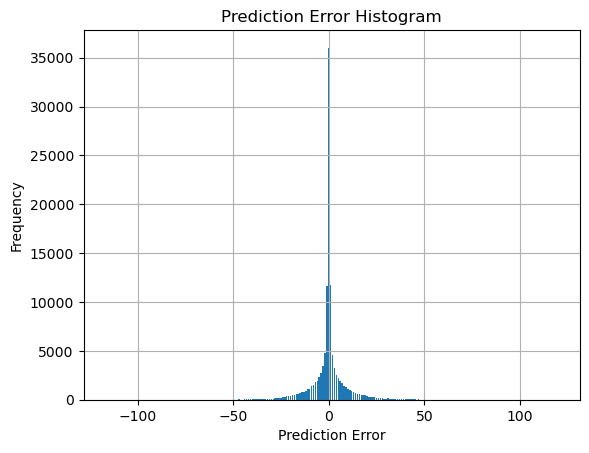

In [5]:
# Step 1: Get prediction error map
errors, locations, preds = get_prediction_error_map(img)
plot_histogram(errors)

# plt.hist(errors, bins = 50, color = 'green')
# plt.show()

In [6]:
# Step 2: Embed data
print("\n Embedding data...")
stego_img, embedded_bits, location_map, peak = embed_data(img, errors, locations, preds, binary_message)
print(f" Embedded {len(embedded_bits)} bits at PE = {peak}")


 Embedding data...
 Embedded 1000 bits at PE = 0


In [7]:
# Step 3: Extract data and restore
print("\nExtracting data...")
extracted_bits, restored_img = extract_data_and_restore(stego_img, location_map, peak)
match = embedded_bits == extracted_bits
print(f"Extracted {len(extracted_bits)} bits")
print('Orginal data :')
print(binary_message)
print('Extracted Data :')
print(np.array(extracted_bits))
print(f"Data Match: {match}")


Extracting data...
Extracted 1000 bits
Orginal data :
[0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 1
 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0
 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1
 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1
 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1
 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1
 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1
 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 1
 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1
 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 

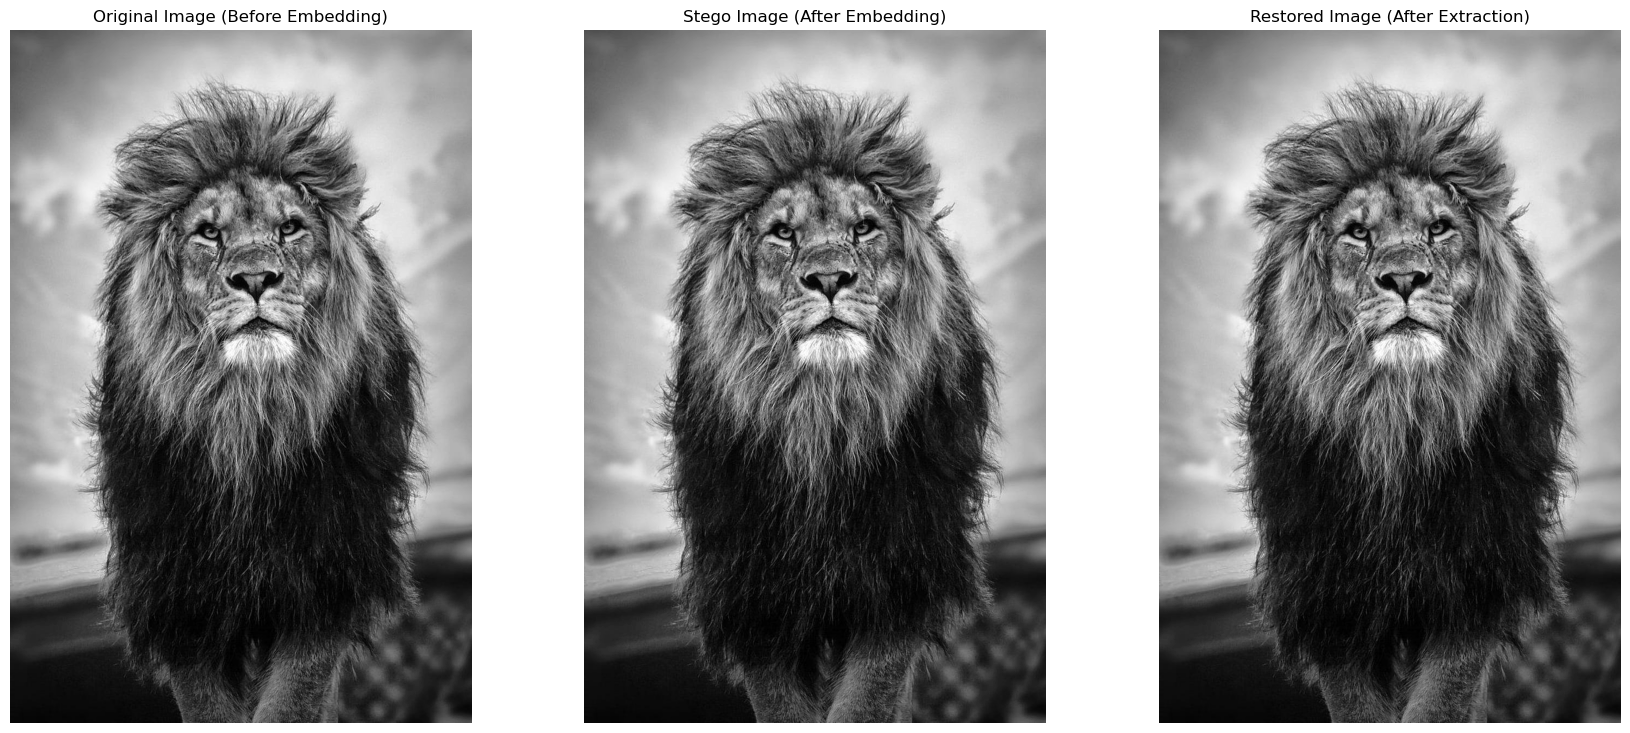

In [8]:
# display all three images

# Show original image
fig = plt.figure(figsize = (21, 9))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image (Before Embedding)")
plt.axis('off')


 # Show stego image
plt.subplot(1, 3, 2)
plt.imshow(stego_img, cmap='gray')
plt.title("Stego Image (After Embedding)")
plt.axis('off')


# Show restored image
plt.subplot(1, 3, 3)
plt.imshow(restored_img, cmap='gray')
plt.title("Restored Image (After Extraction)")
plt.axis('off')
plt.show()

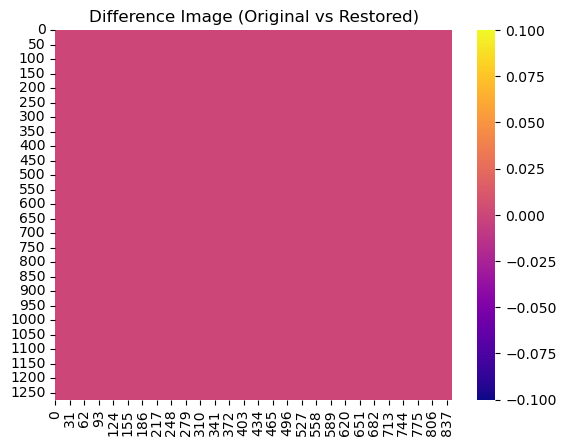

In [9]:
# Displaying error at each point b/w orginal and stego image 
diff = np.abs(img.astype(np.int16) - restored_img.astype(np.int16))
sns.heatmap(diff, cmap = 'plasma')
plt.title("Difference Image (Original vs Restored)")
plt.show()

In [10]:
# checking the model is good fit or not by calculating PSNR(Peak Signal-to-Noise Ratio)

# Step 4: PSNR calculation
psnr = calculate_psnr(img, stego_img)
print(f"\n PSNR (Original vs Stego): {psnr:.2f} dB")


 PSNR (Original vs Stego): 59.21 dB
